# Loading data

In [1]:
from skimage import feature
import zarr
from matplotlib import pyplot as plt
import numpy as np
import SimpleITK as sitk
import tifffile as tif

BASE_PATH = "/Users/camilo.laiton/Documents/images/"

img_1_path = BASE_PATH + "Ex_488_Em_525_468770_468770_830620_012820.zarr/0"
img_2_path = BASE_PATH + "Ex_488_Em_525_501170_501170_830620_012820.zarr/0"

img_3D_path = BASE_PATH + "block_10.tif"

img_1 = zarr.open(img_1_path, "r")[0,0,0, :, 1800:]
img_2 = zarr.open(img_2_path, "r")[0,0,0, :, :200]
img_3d = tif.imread(img_3D_path)[120:184, 200:456, 200: 456]
print("3D image shape: ", img_3d.shape)

3D image shape:  (64, 256, 256)


# 1. Intensity correction tests -> Necessary?

uint16


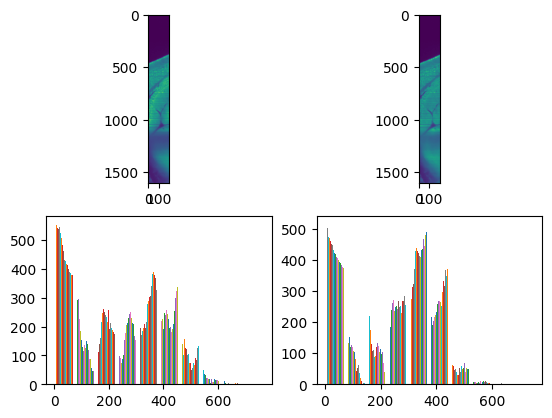

In [84]:
def N4BiasFieldCorrection(image_array):
    input_image = sitk.GetImageFromArray(image_array)
    input_image = sitk.Cast(input_image, sitk.sitkFloat32)
    transformed = sitk.RescaleIntensity(input_image, 0, 255) #1
    transformed = sitk.OtsuThreshold(transformed,0,1)
    
    shrinkFactor = 4 #1
    inputImage = input_image

    inputImage = sitk.Shrink( input_image, [ shrinkFactor ] * inputImage.GetDimension() ) #2
    maskImage = sitk.Shrink( transformed, [ shrinkFactor ] * inputImage.GetDimension() ) #3

    bias_corrector = sitk.N4BiasFieldCorrectionImageFilter() #4

    corrected = bias_corrector.Execute(inputImage, maskImage)

    log_bias_field = bias_corrector.GetLogBiasFieldAsImage(input_image) #1
    corrected_image_full_resolution = input_image / sitk.Exp( log_bias_field ) #2

    return sitk.GetArrayFromImage(corrected_image_full_resolution)

print(img_1.dtype)
corrected_img_1 = N4BiasFieldCorrection(img_1)

f, axarr = plt.subplots(2,2)
axarr[0][0].imshow(img_1)
axarr[0][1].imshow(corrected_img_1)
axarr[1][0].hist(img_1)
axarr[1][1].hist(corrected_img_1)
plt.show()

# 2. FFT to identify keypoints

In [4]:
import functools

def _get_nd_butterworth_filter(shape, factor, order, high_pass, real, dtype=np.float64, squared_butterworth=True):
    """Create a N-dimensional Butterworth mask for an FFT

    Parameters
    ----------
    shape : tuple of int
        Shape of the n-dimensional FFT and mask.
    factor : float
        Fraction of mask dimensions where the cutoff should be.
    order : float
        Controls the slope in the cutoff region.
    high_pass : bool
        Whether the filter is high pass (low frequencies attenuated) or
        low pass (high frequencies are attenuated).
    real : bool
        Whether the FFT is of a real (True) or complex (False) image
    squared_butterworth : bool, optional
        When True, the square of the Butterworth filter is used.

    Returns
    -------
    wfilt : ndarray
        The FFT mask.

    """
    ranges = []
    for i, d in enumerate(shape):
        # start and stop ensures center of mask aligns with center of FFT
        axis = np.arange(-(d - 1) // 2, (d - 1) // 2 + 1) / (d * factor)
        ranges.append(np.fft.ifftshift(axis ** 2))
    # for real image FFT, halve the last axis
    if real:
        limit = d // 2 + 1
        ranges[-1] = ranges[-1][:limit]
    # q2 = squared Euclidean distance grid
    q2 = functools.reduce(
        np.add, np.meshgrid(*ranges, indexing="ij", sparse=True)
    )
    q2 = q2.astype(dtype)
    q2 = np.power(q2, order)
    wfilt = 1 / (1 + q2)
    if high_pass:
        wfilt = 1 - wfilt
    if not squared_butterworth:
        np.sqrt(wfilt, out=wfilt)
    return wfilt

def get_inversed_fft(fft_image):
    is_real = np.isrealobj(fft_image)

    if is_real:
        return np.fft.irfftn(fft_image).real, is_real
    
    return np.fft.ifftn(fft_image).real, is_real

def get_fft(image):
    return np.fft.fftn(image)


50


/var/folders/y3/7hr8m2gn4ds1qgppp68b59k80000gn/T/ipykernel_1685/3857767391.py:42: RuntimeWarning: overflow encountered in power
  q2 = np.power(q2, order)


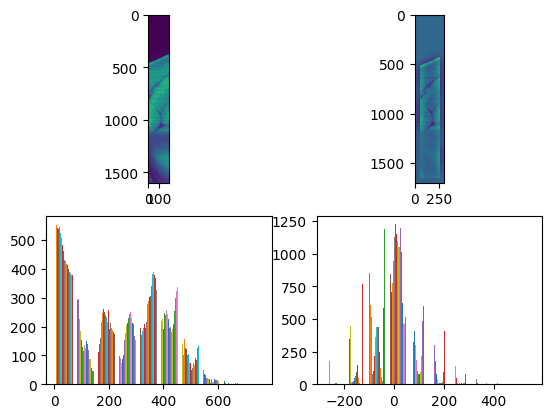

In [5]:
pad_width = np.min(img_1.shape) // 4
print(pad_width)
padded_img_1 = np.pad(array=img_1, mode="constant", pad_width=pad_width)
img_1_fft = get_fft(padded_img_1)
is_real = np.isrealobj(img_1_fft)

butter_filter = _get_nd_butterworth_filter(
    img_1_fft.shape,
    0.005,
    2.0,
    True,
    is_real,
    np.float16,
    True
)

inversed_img_1_fft, is_real_inversed = get_inversed_fft(butter_filter * img_1_fft)
f, axarr = plt.subplots(2,2)
axarr[0][0].imshow(img_1)
axarr[0][1].imshow(inversed_img_1_fft)
axarr[1][0].hist(img_1)
axarr[1][1].hist(inversed_img_1_fft)
plt.show()

## With n4 bias field correction

33


/var/folders/y3/7hr8m2gn4ds1qgppp68b59k80000gn/T/ipykernel_59768/3857767391.py:42: RuntimeWarning: overflow encountered in power
  q2 = np.power(q2, order)


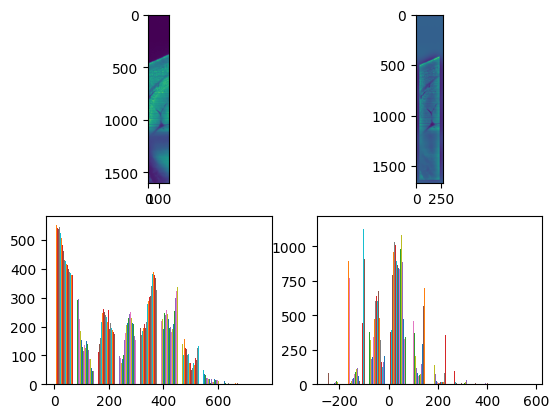

In [177]:
pad_width = np.min(img_1.shape) // 4
print(pad_width)
corrected_padded_img_1 = np.pad(array=corrected_img_1, mode="constant", pad_width=pad_width)
img_1_fft = get_fft(corrected_padded_img_1)
is_real = np.isrealobj(img_1_fft)

butter_filter = _get_nd_butterworth_filter(
    img_1_fft.shape,
    0.005,
    2.0,
    True,
    is_real,
    np.float16,
    True
)

inversed_img_1_fft_n4_corrected, is_real_inversed = get_inversed_fft(butter_filter * img_1_fft)
f, axarr = plt.subplots(2,2)
axarr[0][0].imshow(img_1)
axarr[0][1].imshow(inversed_img_1_fft_n4_corrected)
axarr[1][0].hist(img_1)
axarr[1][1].hist(inversed_img_1_fft_n4_corrected)
plt.show()

# Finding local maxima to identify keypoints

Pad width:  50
Maximum filter size:  12


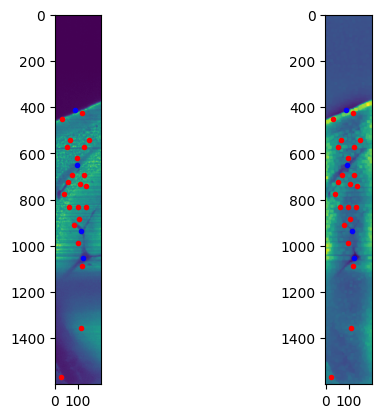

In [6]:
from scipy.ndimage import maximum_filter
from skimage.feature import peak_local_max

print("Pad width: ", pad_width)
maximum_filter_size = pad_width // 4 #20
print("Maximum filter size: ", maximum_filter_size)
inversed_img_1_fft_max_filter = maximum_filter(inversed_img_1_fft, size=maximum_filter_size)

pad_img_shape = inversed_img_1_fft_max_filter.shape
y_low_lim = x_low_lim = pad_width
y_high_lim = pad_img_shape[0] - pad_width
x_high_lim = pad_img_shape[1] - pad_width

inversed_img_1_fft_max_filter = inversed_img_1_fft_max_filter[y_low_lim:y_high_lim, x_low_lim:x_high_lim]
peaks_coordinates = peak_local_max(
    image=inversed_img_1_fft_max_filter,
    min_distance=maximum_filter_size*2,
    threshold_rel=0.2
)

minima_coordinates = peak_local_max(
    image=-inversed_img_1_fft_max_filter,
    min_distance=maximum_filter_size*2,
    threshold_rel=0.2
)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(img_1)
axarr[0].plot(peaks_coordinates[:, 1], peaks_coordinates[:, 0], 'r.') # max points
axarr[0].plot(minima_coordinates[:, 1], minima_coordinates[:, 0], 'b.') # max points

axarr[1].imshow(inversed_img_1_fft_max_filter)
axarr[1].plot(peaks_coordinates[:, 1], peaks_coordinates[:, 0], 'r.') # max points
axarr[1].plot(minima_coordinates[:, 1], minima_coordinates[:, 0], 'b.') # max points


# Gaussian Laplace

Pad width:  50
Maximum filter size:  12


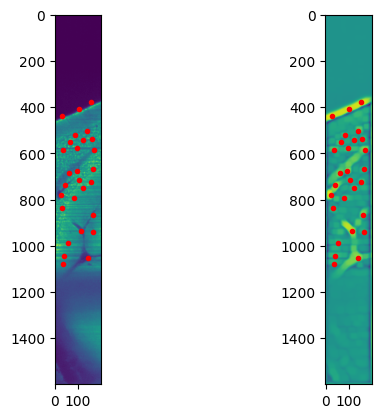

In [7]:
from scipy.ndimage import gaussian_laplace

sigma_xy = 9
inversed_img_1_fft_gauss_lapl = gaussian_laplace(
    inversed_img_1_fft,
    sigma=sigma_xy
)

print("Pad width: ", pad_width)
maximum_filter_size = pad_width // 4 #20
print("Maximum filter size: ", maximum_filter_size)
inversed_img_1_fft_max_filter_gauss = maximum_filter(inversed_img_1_fft_gauss_lapl, size=maximum_filter_size)

pad_img_shape = inversed_img_1_fft_max_filter_gauss.shape
y_low_lim = x_low_lim = pad_width
y_high_lim = pad_img_shape[0] - pad_width
x_high_lim = pad_img_shape[1] - pad_width

inversed_img_1_fft_max_filter_gauss = inversed_img_1_fft_max_filter_gauss[y_low_lim:y_high_lim, x_low_lim:x_high_lim]
peaks_coordinates = peak_local_max(
    image=inversed_img_1_fft_max_filter_gauss,
    min_distance=maximum_filter_size*2,
    threshold_rel=0.2
)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(img_1)
axarr[0].plot(peaks_coordinates[:, 1], peaks_coordinates[:, 0], 'r.') # max points

axarr[1].imshow(inversed_img_1_fft_max_filter_gauss)
axarr[1].plot(peaks_coordinates[:, 1], peaks_coordinates[:, 0], 'r.') # max points

# Difference of gaussians

Pad width:  50
Maximum filter size:  12


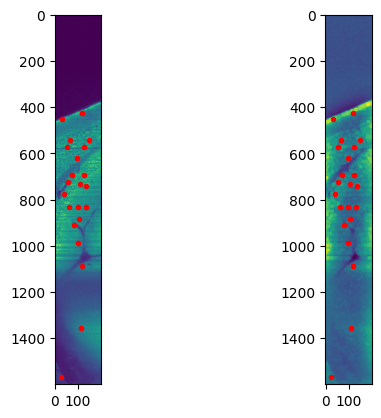

In [6]:
from scipy.ndimage import gaussian_laplace, gaussian_filter, generic_laplace
from skimage.filters import difference_of_gaussians as dog

def kd_difference_of_gaussians(image, low_sigma, high_sigma=None):
    if high_sigma is None:
        high_sigma = low_sigma * 1.6

    if high_sigma < low_sigma:
        raise ValueError('high_sigma must be equal to or larger than'
        'low_sigma for all axes')

    
    low_sigma_image = gaussian_filter(
        image, sigma=low_sigma
    )
    high_sigma_image = gaussian_filter(
        image, sigma=high_sigma
    )

    return low_sigma_image - high_sigma_image

sigma_xy = 5

axes = list(range(inversed_img_1_fft.ndim))
inversed_img_1_fft_dog = inversed_img_1_fft.copy()

for i in range(1, len(axes)):
    tmp = kd_difference_of_gaussians(
        inversed_img_1_fft[i],
        low_sigma=sigma_xy
    )
    inversed_img_1_fft_dog += tmp

print("Pad width: ", pad_width)
maximum_filter_size = pad_width // 4 #20
print("Maximum filter size: ", maximum_filter_size)
inversed_img_1_fft_dog = maximum_filter(inversed_img_1_fft_dog, size=maximum_filter_size)

pad_img_shape = inversed_img_1_fft_dog.shape
y_low_lim = x_low_lim = pad_width
y_high_lim = pad_img_shape[0] - pad_width
x_high_lim = pad_img_shape[1] - pad_width

inversed_img_1_fft_dog = inversed_img_1_fft_dog[y_low_lim:y_high_lim, x_low_lim:x_high_lim]
peaks_coordinates = peak_local_max(
    image=inversed_img_1_fft_dog,
    min_distance=maximum_filter_size*2,
    threshold_rel=0.2
)

f, axarr = plt.subplots(1,2)
axarr[0].imshow(img_1)
axarr[0].plot(peaks_coordinates[:, 1], peaks_coordinates[:, 0], 'r.') # max points

axarr[1].imshow(inversed_img_1_fft_dog)
axarr[1].plot(peaks_coordinates[:, 1], peaks_coordinates[:, 0], 'r.') # max points

# Using kdTree to remove points

I replaced kdTree with non-maxima suppression to be more practical.

48


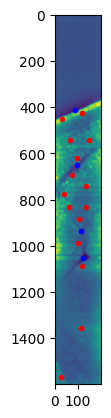

In [5]:
from scipy import spatial

def prune_blobs(blobs_array, distance):
    tree = spatial.cKDTree(blobs_array)
    # tree = spatial.cKDTree(blobs_array[:, :3])
    
    pairs = np.array(list(tree.query_pairs(distance)))
    
    for (i, j) in pairs:
        blob1, blob2 = blobs_array[i], blobs_array[j]
        if blob1[-1] > blob2[-1]:
            blob2[-1] = 0
        else:
            blob1[-1] = 0
    return np.array([b for b in blobs_array if b[-1] > 0])

search_area = maximum_filter_size*4
print(search_area)
pruned_peaks_coordinates = prune_blobs(peaks_coordinates, search_area)
pruned_minima_coordinates = prune_blobs(minima_coordinates, search_area)

plt.imshow(inversed_img_1_fft_max_filter)
plt.plot(pruned_peaks_coordinates[:, 1], pruned_peaks_coordinates[:, 0], 'r.')
plt.plot(pruned_minima_coordinates[:, 1], pruned_minima_coordinates[:, 0], 'b.')
plt.show()

# Algorithm to find keypoints

1. Use padding. For now, it's only zero padding but we could apply other types of padding.
2. Fast-Fourier Transform for both images.
3. Butterworth filter in frecuency domain.
4. Inverse Fast-Fourier Transform to both images.
5. Use morphological maximum filter.
6. Unpad image and get local maximas and minimas from the images.
7. Compute bounding boxes based on a window_size equal to padding size
7. Use non-maxima suppression to prune identified points (created bboxs) in local maximas and minimas for both images.

## Things to improve
1. Eliminating edge responses

In [8]:
from typing import List, Tuple

def non_max_suppression_2D(nd_boxes:List[List[int]], overlap_threshold: float):
    """
    Applies n-dimensional non-maxima
    suppression to a set of bounding
    boxes/cubes using a relative
    overlap threshold.

    Parameters
    -----------
    boxes: List[List[int]]
        List of boxes with where the
        form depends on its dimensionality.
        If it's a 2D image, boxes will be
        [y_start, x_start, y_end, x_end] and
        3D [z_start, y_start, x_start, z_end,
        y_end, x_end]. Start refers to the
        top-left corner and end to top-bottom
        corner.
    
    overlap_threshold: float
        Refers to the relative overlap threshold
        between two bounding boxes or cubes.
    
    Returns
    ----------
    List[int]
        Set of indices after removing overlapped
        boxes/cubes
    """
    n_nd_boxes = len(nd_boxes)

    if n_nd_boxes <= 1:
        return nd_boxes
    
    if nd_boxes.dtype.kind == "i":
        nd_boxes = nd_boxes.astype(np.float32)
    
    pruned_indices = []

    y1 = nd_boxes[:,0]
    x1 = nd_boxes[:,1]
    y2 = nd_boxes[:,2]
    x2 = nd_boxes[:,3]

	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

	# keep looping while some indexes still remain in the indexes
	# list
    while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pruned_indices.append(i)
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlap_threshold)[0])))
	# return only the bounding boxes that were picked using the
	# integer data type
    return pruned_indices

def kd_non_max_suppression(nd_boxes:List[List[int]], overlap_threshold: float, order_axis:str='y'):
    """
    Applies n-dimensional non-maxima
    suppression to a set of bounding
    boxes/cubes using a relative
    overlap threshold.

    Parameters
    -----------
    boxes: List[List[int]]
        List of boxes with where the
        form depends on its dimensionality.
        If it's a 2D image, boxes will be
        [y_start, x_start, y_end, x_end] and
        3D [z_start, y_start, x_start, z_end,
        y_end, x_end]. Start refers to the
        top-left corner and end to top-bottom
        corner.
    
    overlap_threshold: float
        Refers to the relative overlap threshold
        between two bounding boxes or cubes.
    
    order_axis: str
        Axis used to order boxes/cubes.
        Default: 'y'
    
    Returns
    ----------
    List[int]
        Set of indices after removing overlapped
        boxes/cubes
    """
    n_nd_boxes = len(nd_boxes)
    order_axis = order_axis.lower()

    if n_nd_boxes <= 1:
        return nd_boxes
    
    if nd_boxes.dtype.kind == "i":
        nd_boxes = nd_boxes.astype(np.float32)
    
    if order_axis not in ["z", "y", "x"]:
        raise NotImplementedError("This dimension is not available")

    pruned_indices = []
    dimensionality = len(nd_boxes[0]) // 2

    if dimensionality == 2 and order_axis == "z":
        raise ValueError("Providing ordering in Z axis, but only YX available.")

    order_axis_pos = {
        "z": -3,
        "y": -2,
        "x": -1
    }

	# grab the coordinates of the bounding boxes/cubes
    coords = []
    area_list = []
    # Order is [Y X Y X] or [Z Y X Z Y X]
    for idx_dim in range(0, dimensionality*2, 2):
        coords.append(nd_boxes[:, idx_dim])
        coords.append(nd_boxes[:, idx_dim+1])

    for idx_dim in range(dimensionality):
        # [axis]2 - [axis]1 + 1 where [axis] = [Z, Y, X] for 3D        
            area_list.append(
                nd_boxes[:, idx_dim + dimensionality] -
                nd_boxes[:, idx_dim] + 1
            )

	# compute the area of the boxes/cubes and sort
    # by the bottom-right order axis
    if dimensionality == 2:
        area = area_list[0] * area_list[1]
    else:
        area = area_list[0] * area_list[1] * area_list[2]

    idxs = np.argsort(
        coords[order_axis_pos[order_axis]]
    )

    axis = list(range(dimensionality))
    
    while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pruned_indices.append(i)
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        box_cube_area = []
        for ax in axis:
            # e.g., y_end, y_start
            axis_end = np.minimum(
                coords[ax + dimensionality][i], # accessing end corner
                coords[ax + dimensionality][idxs[:last]]
            )

            axis_start = np.maximum(
                coords[ax][i], # accessing start corner
                coords[ax][idxs[:last]]
            )
            
            box_cube_area.append(
                np.maximum(0, axis_end - axis_start + 1)
            )

        if dimensionality == 2:
            box_cube_area = box_cube_area[0] * box_cube_area[1]
        else:
            box_cube_area = box_cube_area[0] * box_cube_area[1] * box_cube_area[1]
        
        # compute the ratio of overlap
        overlap = box_cube_area / area[idxs[:last]]

        # delete all boxes with higher overlap
        # than the threshold
        idxs = np.delete(
            idxs, np.concatenate(
                (
                    [last], 
                    np.where(overlap > overlap_threshold)[0]
                )
            )
        )
	# return only remaining bboxs/cubes
    return np.array(pruned_indices, dtype=int)

def kd_pad_fft_buterworth(image, pad_width=0):

    if pad_width > 0 :
        image = np.pad(array=image, mode="constant", pad_width=pad_width)
    
    img_fft = get_fft(image)
    is_real = np.isrealobj(img_fft)

    butter_filter = _get_nd_butterworth_filter(
        img_fft.shape,
        0.005,
        2.0,
        True,
        is_real,
        np.float16,
        True
    )

    inversed_img_fft, is_real_inversed = get_inversed_fft(butter_filter * img_fft)
    return inversed_img_fft

def kd_max_min_local_points(image, maximum_filter_size, padded=True, max_relative_threshold=.2, min_relative_threshold=.2):
    image_max_filter = maximum_filter(image, size=maximum_filter_size)

    if padded:
        pad_img_shape = image_max_filter.shape
        slices = tuple([slice(pad_width, pad_shape - pad_width) for pad_shape in pad_img_shape])

        image_max_filter = image_max_filter[slices]
    
    # Getting local max points
    maxima_coordinates = peak_local_max(
        image=image_max_filter,
        min_distance=maximum_filter_size*2,
        threshold_rel=max_relative_threshold
    )

    # Getting local minima points
    minima_coordinates = peak_local_max(
        image=-image_max_filter,
        min_distance=maximum_filter_size*2,
        threshold_rel=min_relative_threshold
    )

    return maxima_coordinates, minima_coordinates, image_max_filter

def kd_max_energy_points(image, sigma, maximum_filter_size, padded=True, max_relative_threshold=.2):
    image_gaussian_laplaced = gaussian_laplace(
        input=image,
        sigma=sigma,
        mode="reflect"
    )

    if padded:
        pad_img_shape = image_gaussian_laplaced.shape
        slices = tuple([slice(pad_width, shape - pad_width) for shape in pad_img_shape])

        image_gaussian_laplaced = image_gaussian_laplaced[slices]
    
    # Getting local max points
    max_energy_points = peak_local_max(
        image=image_gaussian_laplaced,
        min_distance=maximum_filter_size*2,
        threshold_rel=max_relative_threshold
    )

    return np.array(max_energy_points, dtype=int), image_gaussian_laplaced

def generate_corner(val, window_size, mode, img_shape, axis):
    possible_val = val + window_size
    
    if mode == "summation":
        if possible_val > img_shape[axis] - 1:
            possible_val = img_shape[axis] - 1

    elif mode == "subtraction":
        possible_val = val - window_size
        if possible_val < 0:
            possible_val = 0

    else:
        raise ValueError("Mode not available")

    return possible_val

def kd_compute_bboxs_cubes(points: List[int], window_size:int, img_shape:Tuple[int]):
    n_dims = len(img_shape)
    img_geometries = []

    if n_dims == 2:
        img_geometries = np.array(
            [
                np.array([
                    # Start top left corner
                    generate_corner(y_val, window_size, "subtraction", img_shape, axis=-2),
                    generate_corner(x_val, window_size, "subtraction", img_shape, axis=-1),
                    # End bottom right corner
                    generate_corner(y_val, window_size, "summation", img_shape, axis=-2),
                    generate_corner(x_val, window_size, "summation", img_shape, axis=-1),
                ])
                for y_val, x_val in points
            ]
        )
    
    elif n_dims == 3:
        img_geometries = np.array(
            [
                np.array([
                    # Start top left corner
                    generate_corner(z_val, window_size, "subtraction", img_shape, axis=-3),
                    generate_corner(y_val, window_size, "subtraction", img_shape, axis=-2),
                    generate_corner(x_val, window_size, "subtraction", img_shape, axis=-1),
                    # End bottom right corner
                    generate_corner(z_val, window_size, "summation", img_shape, axis=-3),
                    generate_corner(y_val, window_size, "summation", img_shape, axis=-2),
                    generate_corner(x_val, window_size, "summation", img_shape, axis=-1),
                ])
                for z_val, y_val, x_val in points
            ]
        )

    return img_geometries

def kd_fft_keypoints(
    image,
    pad_width=0,
    max_relative_threshold=.2,
    min_relative_threshold=.05,
    overlap_threshold=.3
):
    inversed_fft_image = kd_pad_fft_buterworth(image, pad_width=pad_width)

    maximum_filter_size = pad_width // 4
    max_points, min_points, unpadded_img = kd_max_min_local_points(
        inversed_fft_image,
        maximum_filter_size=maximum_filter_size,
        padded=True,
        max_relative_threshold=max_relative_threshold,
        min_relative_threshold=min_relative_threshold
    )

    print("Identified min max points: ", len(max_points), len(min_points))

    # Computing bboxs based on window size = pad_width
    max_bboxs = kd_compute_bboxs_cubes(max_points, pad_width, unpadded_img.shape)
    min_bboxs = kd_compute_bboxs_cubes(min_points, pad_width, unpadded_img.shape)

    # Non-max suppression with created bboxs
    idxs_pruned_max_bboxs = kd_non_max_suppression(max_bboxs, overlap_threshold)
    idxs_pruned_min_bboxs = kd_non_max_suppression(min_bboxs, overlap_threshold)
    
    print("Idxs pruned max min: ", idxs_pruned_max_bboxs, idxs_pruned_min_bboxs)

    pruned_max_points = max_points.copy()
    pruned_min_points = min_points.copy()

    # Getting non-max prunned points
    if len(idxs_pruned_max_bboxs):
        pruned_max_points = max_points[idxs_pruned_max_bboxs]
    
    if len(idxs_pruned_min_bboxs):
        pruned_min_points = min_points[idxs_pruned_min_bboxs]

    print("Identified min max points after suppression: ", len(pruned_max_points), len(pruned_min_points))

    return pruned_max_points, pruned_min_points, unpadded_img

def kd_fft_energy_keypoints(
    image,
    pad_width=0,
    sigma=9,
    max_relative_threshold=.2,
    overlap_threshold=.3,
):
    inversed_fft_image = kd_pad_fft_buterworth(image, pad_width=pad_width)
    maximum_filter_size = pad_width // 4

    energy_points, unpadded_img = kd_max_energy_points(
        image=inversed_fft_image,
        sigma=sigma,
        maximum_filter_size=maximum_filter_size,
        padded=True,
        max_relative_threshold=max_relative_threshold
    )

    print("Identified min max points: ", len(energy_points))

    # Computing bboxs based on window size = pad_width
    max_bboxs = kd_compute_bboxs_cubes(energy_points, pad_width, unpadded_img.shape)

    # Non-max suppression with created bboxs
    idxs_pruned_energy_bboxs = kd_non_max_suppression(max_bboxs, overlap_threshold)
    
    print("Idxs pruned max min: ", idxs_pruned_energy_bboxs)
    pruned_max_points = energy_points.copy()

    # Getting non-max prunned points
    if len(idxs_pruned_energy_bboxs):
        pruned_max_points = energy_points[idxs_pruned_energy_bboxs]

    print("Identified energy points after suppression: ", len(pruned_max_points))

    return pruned_max_points, unpadded_img


/var/folders/y3/7hr8m2gn4ds1qgppp68b59k80000gn/T/ipykernel_1685/3857767391.py:42: RuntimeWarning: overflow encountered in power
  q2 = np.power(q2, order)


Identified min max points:  22 4
Idxs pruned max min:  [15 19 14 18 16 20  4  2  9 13  7 10  0  1] [0 2 3 1]
Identified min max points after suppression:  14 4
Identified min max points:  16 4
Idxs pruned max min:  [14 15 11 13 10  5  2  0  6  8  1] [0 1 3]
Identified min max points after suppression:  11 3


<Figure size 1600x1600 with 0 Axes>

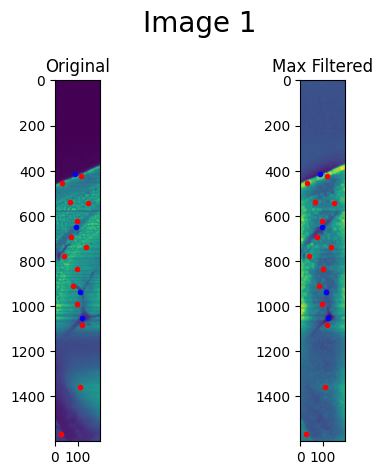

<Figure size 1600x1600 with 0 Axes>

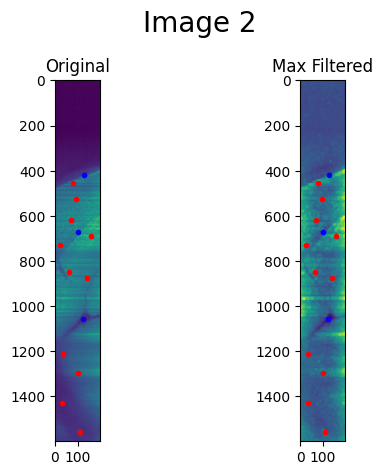

<Figure size 1600x1600 with 0 Axes>

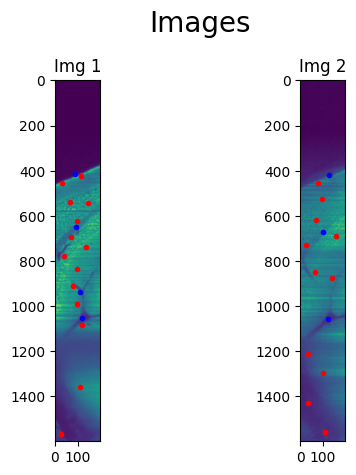

<Figure size 1600x1600 with 0 Axes>

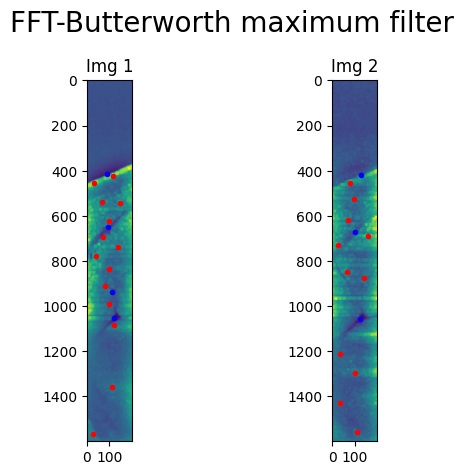

In [9]:
from matplotlib.pyplot import figure

pad_width = np.min(img_1.shape) // 4
max_img_1_keypoints, min_img_1_keypoints, filtered_img_1 = kd_fft_keypoints(image=img_1, pad_width=pad_width)
max_img_2_keypoints, min_img_2_keypoints, filtered_img_2 = kd_fft_keypoints(image=img_2, pad_width=pad_width)

# comparison img1 filters

figure(figsize=(20, 20), dpi=80)
f, axarr = plt.subplots(1,2)
f.suptitle('Image 1', fontsize=20)
axarr[0].set_title("Original")
axarr[0].imshow(img_1)
axarr[0].plot(max_img_1_keypoints[:, 1], max_img_1_keypoints[:, 0], 'r.') # max points
axarr[0].plot(min_img_1_keypoints[:, 1], min_img_1_keypoints[:, 0], 'b.') # min points

axarr[1].set_title("Max Filtered")
axarr[1].imshow(filtered_img_1)
axarr[1].plot(max_img_1_keypoints[:, 1], max_img_1_keypoints[:, 0], 'r.') # max points
axarr[1].plot(min_img_1_keypoints[:, 1], min_img_1_keypoints[:, 0], 'b.') # max points

plt.tight_layout()
plt.show()

# comparison img2 filters

figure(figsize=(20, 20), dpi=80)
f, axarr = plt.subplots(1,2)

f.suptitle('Image 2', fontsize=20)
axarr[0].set_title("Original")
axarr[0].imshow(img_2)
axarr[0].plot(max_img_2_keypoints[:, 1], max_img_2_keypoints[:, 0], 'r.') # max points
axarr[0].plot(min_img_2_keypoints[:, 1], min_img_2_keypoints[:, 0], 'b.') # min points

axarr[1].set_title("Max Filtered")
axarr[1].imshow(filtered_img_2)
axarr[1].plot(max_img_2_keypoints[:, 1], max_img_2_keypoints[:, 0], 'r.') # max points
axarr[1].plot(min_img_2_keypoints[:, 1], min_img_2_keypoints[:, 0], 'b.') # max points
plt.tight_layout()
plt.show()

# comparison img1 - img2

figure(figsize=(20, 20), dpi=80)
f, axarr = plt.subplots(1,2)

f.suptitle('Images', fontsize=20)
axarr[0].set_title("Img 1")
axarr[0].imshow(img_1)
axarr[0].plot(max_img_1_keypoints[:, 1], max_img_1_keypoints[:, 0], 'r.') # max points
axarr[0].plot(min_img_1_keypoints[:, 1], min_img_1_keypoints[:, 0], 'b.') # min points

axarr[1].set_title("Img 2")
axarr[1].imshow(img_2)
axarr[1].plot(max_img_2_keypoints[:, 1], max_img_2_keypoints[:, 0], 'r.') # max points
axarr[1].plot(min_img_2_keypoints[:, 1], min_img_2_keypoints[:, 0], 'b.') # max points
plt.tight_layout()
plt.show()

# comparison filtered1 - filtered2

figure(figsize=(20, 20), dpi=80)
f, axarr = plt.subplots(1,2)

f.suptitle('FFT-Butterworth maximum filter', fontsize=20)
axarr[0].set_title("Img 1")
axarr[0].imshow(filtered_img_1)
axarr[0].plot(max_img_1_keypoints[:, 1], max_img_1_keypoints[:, 0], 'r.') # max points
axarr[0].plot(min_img_1_keypoints[:, 1], min_img_1_keypoints[:, 0], 'b.') # min points

axarr[1].set_title("Img 2")
axarr[1].imshow(filtered_img_2)
axarr[1].plot(max_img_2_keypoints[:, 1], max_img_2_keypoints[:, 0], 'r.') # max points
axarr[1].plot(min_img_2_keypoints[:, 1], min_img_2_keypoints[:, 0], 'b.') # max points
plt.tight_layout()
plt.show()

/var/folders/y3/7hr8m2gn4ds1qgppp68b59k80000gn/T/ipykernel_1685/3857767391.py:42: RuntimeWarning: overflow encountered in power
  q2 = np.power(q2, order)


Identified min max points:  34
Idxs pruned max min:  [32 24  6 22  4 10 33 17  5  7  8 13 21 11 28  2]
Identified energy points after suppression:  16
Identified min max points:  42
Idxs pruned max min:  [41 27 33  4  1 10 12 25  9  0 26 23 22 29 13 21 15 36 19  5]
Identified energy points after suppression:  20


<Figure size 1600x1600 with 0 Axes>

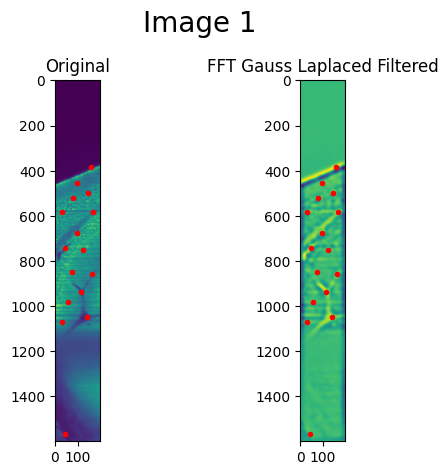

<Figure size 1600x1600 with 0 Axes>

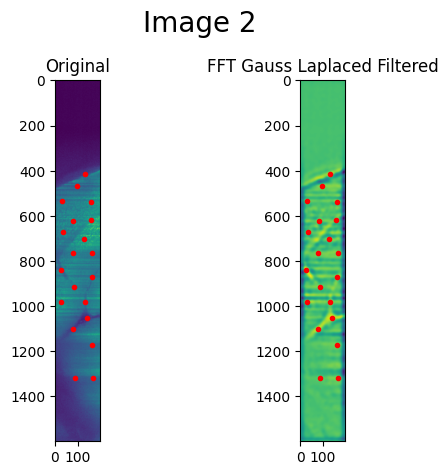

<Figure size 1600x1600 with 0 Axes>

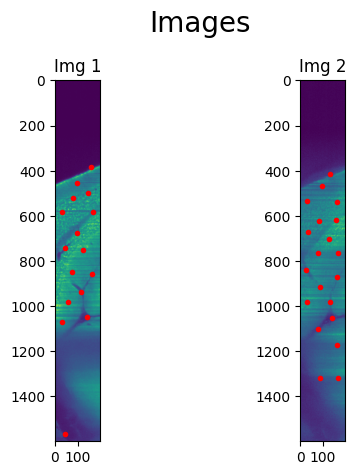

<Figure size 1600x1600 with 0 Axes>

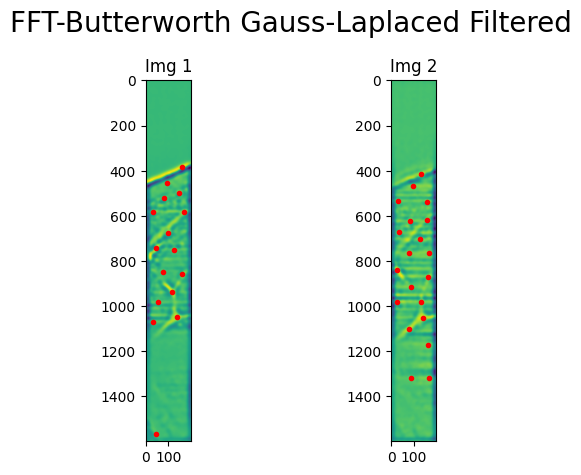

In [10]:
pad_width = np.min(img_1.shape) // 4
img_1_keypoints_energy, filtered_img_1 = kd_fft_energy_keypoints(image=img_1, pad_width=pad_width)
img_2_keypoints_energy, filtered_img_2 = kd_fft_energy_keypoints(image=img_2, pad_width=pad_width)

# comparison img1 filters

figure(figsize=(20, 20), dpi=80)
f, axarr = plt.subplots(1,2)
f.suptitle('Image 1', fontsize=20)
axarr[0].set_title("Original")
axarr[0].imshow(img_1)
axarr[0].plot(img_1_keypoints_energy[:, 1], img_1_keypoints_energy[:, 0], 'r.') # max points

axarr[1].set_title("FFT Gauss Laplaced Filtered")
axarr[1].imshow(filtered_img_1)
axarr[1].plot(img_1_keypoints_energy[:, 1], img_1_keypoints_energy[:, 0], 'r.') # max points

plt.tight_layout()
plt.show()

# comparison img2 filters

figure(figsize=(20, 20), dpi=80)
f, axarr = plt.subplots(1,2)

f.suptitle('Image 2', fontsize=20)
axarr[0].set_title("Original")
axarr[0].imshow(img_2)
axarr[0].plot(img_2_keypoints_energy[:, 1], img_2_keypoints_energy[:, 0], 'r.') # max points

axarr[1].set_title("FFT Gauss Laplaced Filtered")
axarr[1].imshow(filtered_img_2)
axarr[1].plot(img_2_keypoints_energy[:, 1], img_2_keypoints_energy[:, 0], 'r.') # max points
plt.tight_layout()
plt.show()

# comparison img1 - img2

figure(figsize=(20, 20), dpi=80)
f, axarr = plt.subplots(1,2)

f.suptitle('Images', fontsize=20)
axarr[0].set_title("Img 1")
axarr[0].imshow(img_1)
axarr[0].plot(img_1_keypoints_energy[:, 1], img_1_keypoints_energy[:, 0], 'r.') # max points

axarr[1].set_title("Img 2")
axarr[1].imshow(img_2)
axarr[1].plot(img_2_keypoints_energy[:, 1], img_2_keypoints_energy[:, 0], 'r.') # max points
plt.tight_layout()
plt.show()

# comparison filtered img1 - img2

figure(figsize=(20, 20), dpi=80)
f, axarr = plt.subplots(1,2)

f.suptitle('FFT-Butterworth Gauss-Laplaced Filtered', fontsize=20)
axarr[0].set_title("Img 1")
axarr[0].imshow(filtered_img_1)
axarr[0].plot(img_1_keypoints_energy[:, 1], img_1_keypoints_energy[:, 0], 'r.') # max points

axarr[1].set_title("Img 2")
axarr[1].imshow(filtered_img_2)
axarr[1].plot(img_2_keypoints_energy[:, 1], img_2_keypoints_energy[:, 0], 'r.') # max points
plt.tight_layout()
plt.show()

## Testing approach with 3D

In [11]:
%%time
pad_width = np.min(img_3d.shape) // 4
print(pad_width, img_3d.shape)
img_3d_keypoints, img = kd_fft_energy_keypoints(
    image=img_3d,
    pad_width=pad_width,
)
print(len(img_3d_keypoints))

16 (64, 256, 256)


/var/folders/y3/7hr8m2gn4ds1qgppp68b59k80000gn/T/ipykernel_1685/3857767391.py:42: RuntimeWarning: overflow encountered in power
  q2 = np.power(q2, order)


Identified min max points:  23
Idxs pruned max min:  [15  1 12  4 20  0  6 19  7  9  3]
Identified energy points after suppression:  11
11
CPU times: user 2.74 s, sys: 148 ms, total: 2.89 s
Wall time: 2.92 s


In [12]:
%%time
pad_width = np.min(img_3d.shape) // 4
print(pad_width, img_3d.shape)
max_img_3d_keypoints, min_img_3d_keypoints, img = kd_fft_keypoints(
    image=img_3d,
    pad_width=pad_width,
)
print(len(max_img_3d_keypoints) + len(min_img_2_keypoints))

16 (64, 256, 256)


/var/folders/y3/7hr8m2gn4ds1qgppp68b59k80000gn/T/ipykernel_1685/3857767391.py:42: RuntimeWarning: overflow encountered in power
  q2 = np.power(q2, order)


Identified min max points:  25 0
Idxs pruned max min:  [23  9 10  4 18  2 12  1 21 24 11 20  6 16 19] []
Identified min max points after suppression:  15 0
18
CPU times: user 1.34 s, sys: 9.74 ms, total: 1.35 s
Wall time: 1.35 s


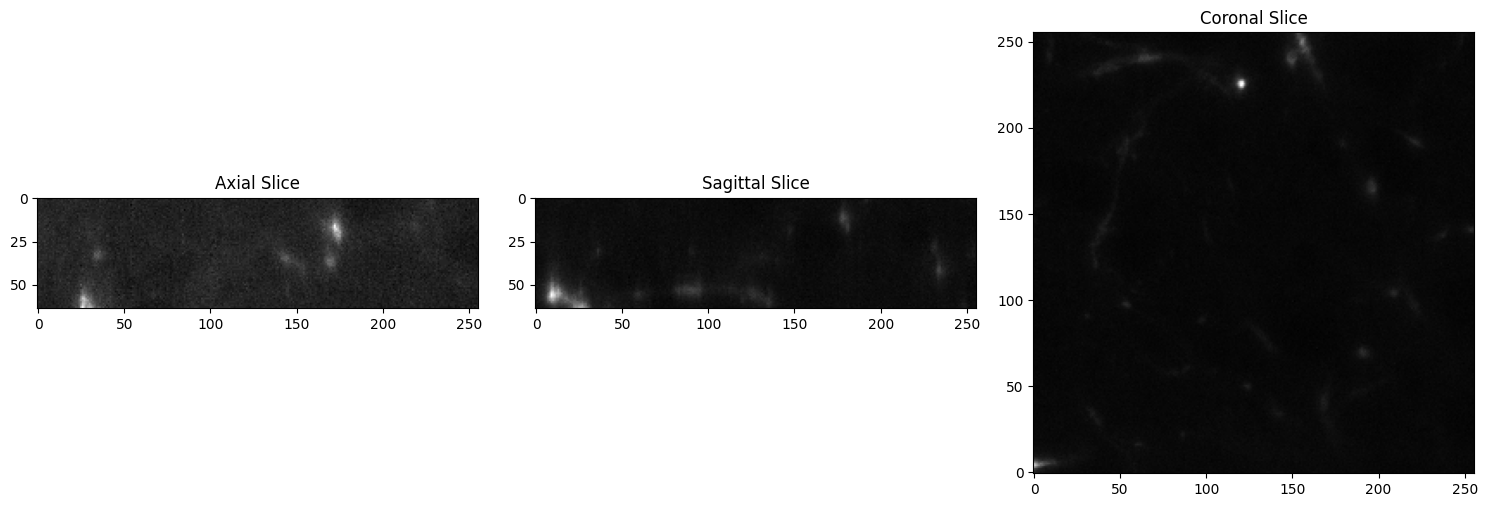

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Load a 3D image as an example (replace with your own image)
image = img_3d.copy()

# Display axial, sagittal, and coronal slices
num_slices = image.shape[0]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(image[:, :, num_slices // 2], cmap='gray')
axes[0].set_title('Axial Slice')
axes[1].imshow(image[:, num_slices // 2, :], cmap='gray')
axes[1].set_title('Sagittal Slice')
axes[2].imshow(image[num_slices // 2, :, :].T, cmap='gray', origin='lower')
axes[2].set_title('Coronal Slice')

plt.tight_layout()
plt.show()


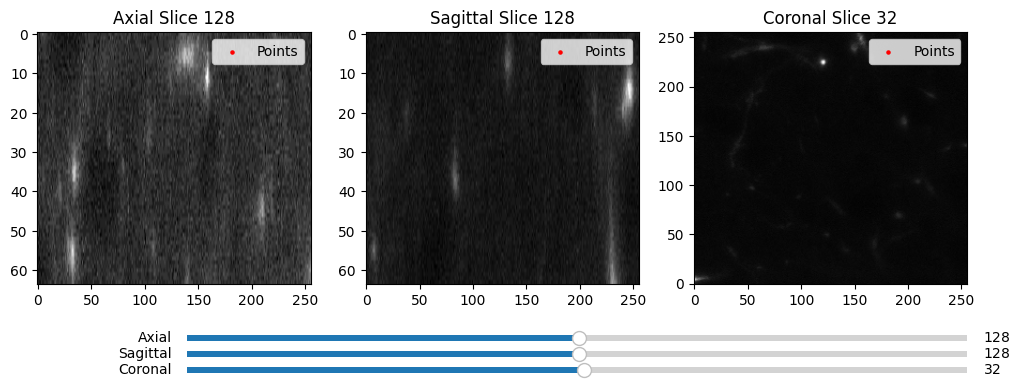

In [49]:
from matplotlib.widgets import Slider

# Generate random 3D points for demonstration
num_points = 100
np.random.seed(42)
points = np.random.randint(0, image.shape[0], size=(num_points, 3))

# Create a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
plt.subplots_adjust(bottom=0.25)

# Initial slice indices and point size
initial_slice_axial = image.shape[2] // 2
initial_slice_sagittal = image.shape[1] // 2
initial_slice_coronal = image.shape[0] // 2
point_size = 5

# Display the initial slices
im_axial = axs[0].imshow(image[:, :, initial_slice_axial], cmap='gray', aspect='auto')
im_sagittal = axs[1].imshow(image[:, initial_slice_sagittal, :], cmap='gray', aspect='auto')
im_coronal = axs[2].imshow(image[initial_slice_coronal, :, :].T, cmap='gray', origin='lower', aspect='auto')

# Set titles for subplots
axs[0].set_title(f'Axial Slice {initial_slice_axial}')
axs[1].set_title(f'Sagittal Slice {initial_slice_sagittal}')
axs[2].set_title(f'Coronal Slice {initial_slice_coronal}')

# Create sliders
ax_slider_axial = plt.axes([0.25, 0.1, 0.65, 0.03])
ax_slider_sagittal = plt.axes([0.25, 0.06, 0.65, 0.03])
ax_slider_coronal = plt.axes([0.25, 0.02, 0.65, 0.03])

slider_axial = Slider(ax_slider_axial, 'Axial', 0, image.shape[2] - 1, valinit=initial_slice_axial, valstep=1)
slider_sagittal = Slider(ax_slider_sagittal, 'Sagittal', 0, image.shape[1] - 1, valinit=initial_slice_sagittal, valstep=1)
slider_coronal = Slider(ax_slider_coronal, 'Coronal', 0, image.shape[0] - 1, valinit=initial_slice_coronal, valstep=1)

# Function to update displayed slices
def update(val):
    slice_index_axial = int(slider_axial.val)
    slice_index_sagittal = int(slider_sagittal.val)
    slice_index_coronal = int(slider_coronal.val)
    
    im_axial.set_data(image[:, :, slice_index_axial])
    im_sagittal.set_data(image[:, slice_index_sagittal, :])
    im_coronal.set_data(image[slice_index_coronal, :, :].T)
    
    axs[0].set_title(f'Axial Slice {slice_index_axial}')
    axs[1].set_title(f'Sagittal Slice {slice_index_sagittal}')
    axs[2].set_title(f'Coronal Slice {slice_index_coronal}')
    
    scatter_axial.set_offsets(points[points[:, 2] == slice_index_axial, :2])
    scatter_sagittal.set_offsets(points[points[:, 1] == slice_index_sagittal, [0, 2]])
    scatter_coronal.set_offsets(points[points[:, 0] == slice_index_coronal, [1, 2]])
    
    fig.canvas.draw_idle()

# Link the sliders to the update function
slider_axial.on_changed(update)
slider_sagittal.on_changed(update)
slider_coronal.on_changed(update)

# Create scatter plots for the points
scatter_axial = axs[0].scatter([], [], c='r', s=point_size, label='Points')
scatter_sagittal = axs[1].scatter([], [], c='r', s=point_size, label='Points')
scatter_coronal = axs[2].scatter([], [], c='r', s=point_size, label='Points')

# Set legend for the scatter plots
axs[0].legend()
axs[1].legend()
axs[2].legend()

# Show the plot
plt.show()

# Feature decriptor experiments

Identified min max points:  22 4
Idxs pruned max min:  [15 19 14 18 16 20  4  2  9 13  7 10  0  1] [0 2 3 1]
Identified min max points after suppression:  14 4


/var/folders/y3/7hr8m2gn4ds1qgppp68b59k80000gn/T/ipykernel_1685/3857767391.py:42: RuntimeWarning: overflow encountered in power
  q2 = np.power(q2, order)


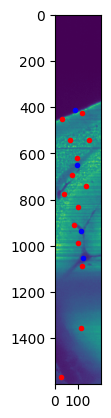

In [13]:
pad_width = np.min(img_1.shape) // 4
img_1_keypoints = kd_fft_keypoints(image=img_1, pad_width=pad_width)

f, axarr = plt.subplots(1,1)
axarr.imshow(img_1)
axarr.plot(img_1_keypoints[0][:, 1], img_1_keypoints[0][:, 0], 'r.') # max points
axarr.plot(img_1_keypoints[1][:, 1], img_1_keypoints[1][:, 0], 'b.') # min points
plt.show()

Getting image gradients, gradient magnitudes and direction

(1600, 200) (1600, 200)


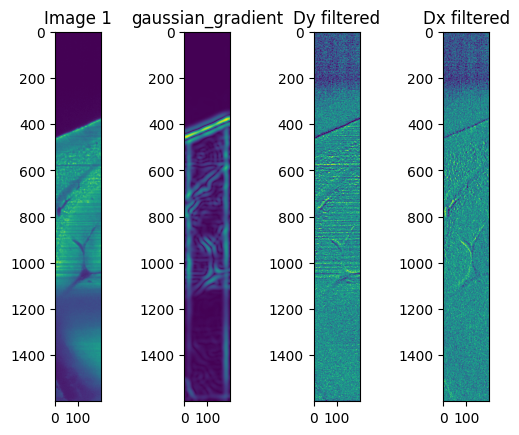

In [24]:
from scipy.ndimage import gaussian_gradient_magnitude, sobel

def derivate_image_axis(image, axis:List[int], n_lvls=1):

    if len(axis) == 0:
        ValueError("Please, provide a list with the axis")
    
    derivatives = []

    for ax in axis:
        derivatives.append(
            np.diff(image, n=n_lvls, axis=ax)
        )
    
    return derivatives

gaussian_gradient = gaussian_gradient_magnitude(
    filtered_img_1,
    sigma_xy,
    mode='reflect'
)

dy_val, dx_val = derivate_image_axis(
    img_1, [0, 1]
)

filtered_img_1_dy = np.zeros(img_1.shape, dtype=img_1.dtype)
filtered_img_1_dx = np.zeros(img_1.shape, dtype=img_1.dtype)

filtered_img_1_dy[:-1, :] = np.float32(dy_val)
filtered_img_1_dx[:, :-1] = np.float32(dx_val)

print(filtered_img_1_dx.shape, filtered_img_1_dy.shape)

f, axarr = plt.subplots(1,4)
axarr[0].set_title("Image 1")
axarr[0].imshow(img_1)
axarr[1].set_title("gaussian_gradient")
axarr[1].imshow(gaussian_gradient)
axarr[2].set_title("Dy filtered")
axarr[2].imshow(filtered_img_1_dy)
axarr[3].set_title("Dx filtered")
axarr[3].imshow(filtered_img_1_dx)

plt.show()


Gradient orientation:  [[0.0000000e+00 7.8539819e-01 1.1065722e-01 ... 7.8539819e-01
  0.0000000e+00 1.5707964e+00]
 [0.0000000e+00 0.0000000e+00 1.5707506e+00 ... 1.5707964e+00
  0.0000000e+00 1.5707964e+00]
 [0.0000000e+00 0.0000000e+00 1.3101939e+00 ... 7.8539819e-01
  0.0000000e+00 1.5707964e+00]
 ...
 [1.0338856e+00 1.5262049e-04 1.5706131e+00 ... 1.5704910e+00
  7.8542107e-01 1.5707964e+00]
 [3.9677086e-04 2.4427107e-04 5.4940855e-04 ... 5.6931317e-01
  1.3597029e+00 1.5707964e+00]
 [0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]]
(1600, 200) (1600, 200) 2.5464790894703255 [-3.141592653589793, -2.356194490192345, -1.5707963267948966, -0.7853981633974483, 0.0, 0.7853981633974483, 1.5707963267948966, 2.356194490192345]


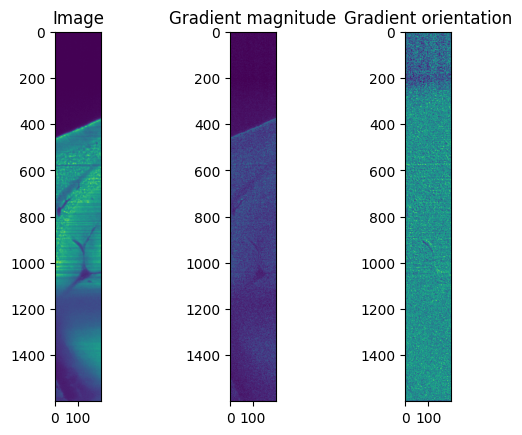

In [50]:
def kd_gradient_magnitudes_and_orientations(derivated_images:List[np.array]):
    """
    Computes the gradient magnitudes and orientations
    for a 2D or 3D image.

    Parameters
    ------------
    derivated_images: List[np.array]
        List with the derivated images in
        [Dy, Dx] order for a 2D image or
        [Dz, Dy, Dx] order for a 3D image
    
    Returns
    ------------
    Tuple
        Tuple with the gradient magnitude
        (radius in spherical coordinates),
        theta for a 3D image referring to
        the polar angle and phi as the
        azimuthal angle (in 2D angle between
        a point from the origin (0,0) 
        and point (x,y) )
    """
    n_dims = len(derivated_images)

    if n_dims <= 1 and n_dims > 3:
        raise ValueError("Only 2D or 3D images are allowed")

    powered_derivatives = np.power(derivated_images, 2)
    sum_powered_derivatives = np.sum(powered_derivatives, axis=0)
    # also called radius in spherical coordinates
    gradient_magnitude = np.sqrt(sum_powered_derivatives)
    phi = None
    theta = None

    if n_dims == 2:
        # Angle between origin and point x,y in a circle
        phi = np.arctan2(derivated_images[0], derivated_images[1])
    
    else:
        # Angle between origin and point x,y,z in a sphere
        phi = np.arctan2(derivated_images[1], derivated_images[2])
        theta = np.arccos(derivated_images[0] / gradient_magnitude)
    
    return gradient_magnitude, phi, theta

# Getting magnitudes and orientations
gradient_magnitude, gradient_orientation_yx, gradient_orientation_polar = kd_gradient_magnitudes_and_orientations(
    derivated_images=[filtered_img_1_dy, filtered_img_1_dx] # Must be in order ZYX in 3D or YX for 2D
)

print("Gradient orientation: ", gradient_orientation_yx)

n_orientations = 8 # Usually, it's 8 check FLANN algorithm, deisy
orientation = n_orientations / np.pi
orientation_angles = [2 * o * np.pi / n_orientations - np.pi for o in range(n_orientations)]

print(gradient_magnitude.shape, gradient_orientation_yx.shape, orientation, orientation_angles)

f, axarr = plt.subplots(1,3)
axarr[0].set_title("Image")
axarr[0].imshow(img_1)
axarr[1].set_title("Gradient magnitude")
axarr[1].imshow(gradient_magnitude)
axarr[2].set_title("Gradient orientation")
axarr[2].imshow(gradient_orientation_yx)

plt.show()

In [51]:
pixels_per_cell=(8, 8)
cells_per_block=(3, 3)

image_height, image_width = gradient_orientation_yx.shape
pixel_height, pixel_width = pixels_per_cell
cell_block_height, cell_block_width = cells_per_block

print(image_height, image_width)

n_cells_height = int( image_height // pixel_height )
n_cells_width = int( image_width // pixel_width )

print(n_cells_height, n_cells_width)

1600 200
200 25


In [ ]:
hist = np.empty((n_orientations,) + image.shape, dtype=np.float32)
for i, o in enumerate(orientation_angles):
    # Weigh bin contribution by the circular normal distribution
    hist[i, :, :] = np.exp(orientation * np.cos(grad_ori - o))
    # Weigh bin contribution by the gradient magnitude
    hist[i, :, :] = np.multiply(hist[i, :, :], grad_mag)

/Users/camilo.laiton/opt/anaconda3/envs/reg_eval/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


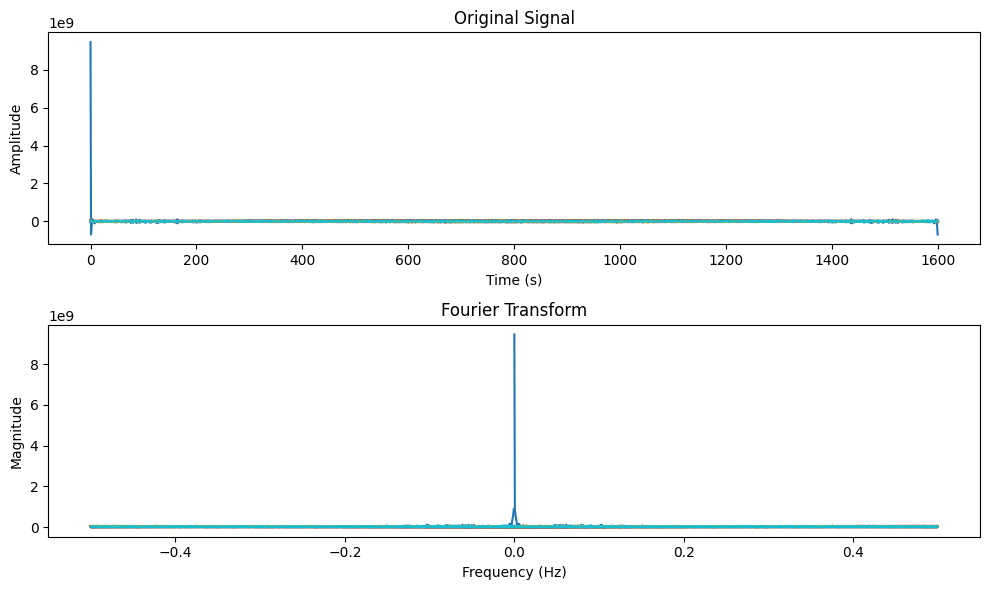

In [25]:

test_img = np.fft.fftn(filtered_img_1_dy)

magnitude = np.abs(test_img)

# Plot the original signal and its Fourier Transform
plt.figure(figsize=(10, 6))

frequency_bins = np.fft.fftfreq(len(test_img), 1)

plt.subplot(2, 1, 1)
plt.plot(test_img)
plt.title('Original Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(frequency_bins, magnitude)
plt.title('Fourier Transform')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()

## Utilities that didn't work

Window size:  50
Image shape:  (1600, 200)


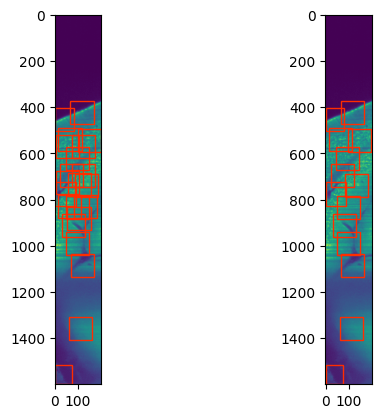

In [212]:
# from matplotlib.patches import Rectangle

# window_size = pad_width
# print("Window size: ", window_size)#, " - Image keypoints: ", img_1_keypoints[0])

# img_shape = img_1.shape
# print("Image shape: ", img_shape)

# fig, ax = plt.subplots(1, 2)

# for bbox in img_1_bbox:
#     ax[0].add_patch(
#         Rectangle(
#             xy=(bbox[0], bbox[1]),
#             width=bbox[2] - bbox[0],
#             height=bbox[3] - bbox[1],
#             linewidth=1,
#             edgecolor="#FF2D00",
#             facecolor="none",
#             linestyle="-",
#         )
#     )

# for bbox in suppressed_bbox:
#     ax[1].add_patch(
#         Rectangle(
#             xy=(bbox[0], bbox[1]),
#             width=bbox[2] - bbox[0],
#             height=bbox[3] - bbox[1],
#             linewidth=1,
#             edgecolor="#FF2D00",
#             facecolor="none",
#             linestyle="-",
#         )
#     )

# ax[0].imshow(img_1)
# ax[1].imshow(img_1)

# plt.show()

In [ ]:

# It's better to use RANSAC for outlier detection
def mad_based_outlier(points, thresh=3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

def percentile_based_outlier(data, threshold=95):
    diff = (100 - threshold) / 2.0
    minval, maxval = np.percentile(data, [diff, 100 - diff])
    return (data < minval) | (data > maxval)

# Getting window size for a point
window_size = maximum_filter_size

def generate_grid_for_point(point, window_size, dims):
    points_per_dim = [
        np.expand_dims(
            np.linspace(
                start=point[idx_dim] - window_size,
                stop=point[idx_dim] + window_size,
                num=2 * window_size + 1,
                dtype=np.uint32
            ),
            axis=0,
        )
        for idx_dim in range(dims)
    ]

    points_per_dim = tuple(points_per_dim)

    grid_per_dim = np.meshgrid(*points_per_dim, indexing="ij")
    grid_per_dim = [grid_dim.flatten() for grid_dim in grid_per_dim]

    point_windowed = np.vstack(grid_per_dim)
    return point_windowed

# peak_coord_dict = {}
# for point in peaks_coordinates:
#     point_grid = generate_grid_for_point(point, window_size, 2)
#     median_point_grid = np.median(
#         inversed_img_1_fft_max_filter[point_grid[0], point_grid[1]]
#     )
#     peak_coord_dict[point] = median_point_grid

# min_val, max_val = np.percentile(data_points_windowed, [0, 40])#data_points_windowed[percentile_based_outlier(data_points_windowed)]
# outliers_index = (data_points_windowed < min_val) | (data_points_windowed > max_val)
# after_removing_outliers = data_points_windowed[outliers_index]

# initial_index = data_points_windowed.index(after_removing_outliers[0])
# pruned_peak_coordinates = peaks_coordinates()

# print("Outliers: ", after_removing_outliers, "Median: ", np.median(data_points_windowed), "data points: ", data_points_windowed)
# reshape_size = (window_size * 2) + 1
# print(peaks_coordinates[0], points_windowed[0][0], points_windowed[0][1])
# img_windowed = inversed_img_1_fft_max_filter[points_windowed[0][0], points_windowed[0][1]].reshape(reshape_size, reshape_size)
# print(img_windowed.shape)

# f, axarr = plt.subplots(1,2)
# axarr[0].imshow(inversed_img_1_fft_max_filter)
# axarr[1].imshow(img_windowed)

# print(img_windowed.shape)
# peaks_coordinates_data = [inversed_img_1_fft[] for peak in peaks_coordinates]

# peaks_coordinates_filter_outliers = mad_based_outlier(points=peaks_coordinates_data)
